In [1]:
import os
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter , defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing import image




In [ ]:
#  دیتاست
dataset_path = r"C:\Users\omid\OneDrive\Desktop\toyota_cars"


In [3]:
# خواندن لیبل‌ها (نام پوشه‌ها)
labels = []
image_paths = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(folder)


In [4]:
# نمایش نمودار فراوانی
label_counts = Counter(labels)


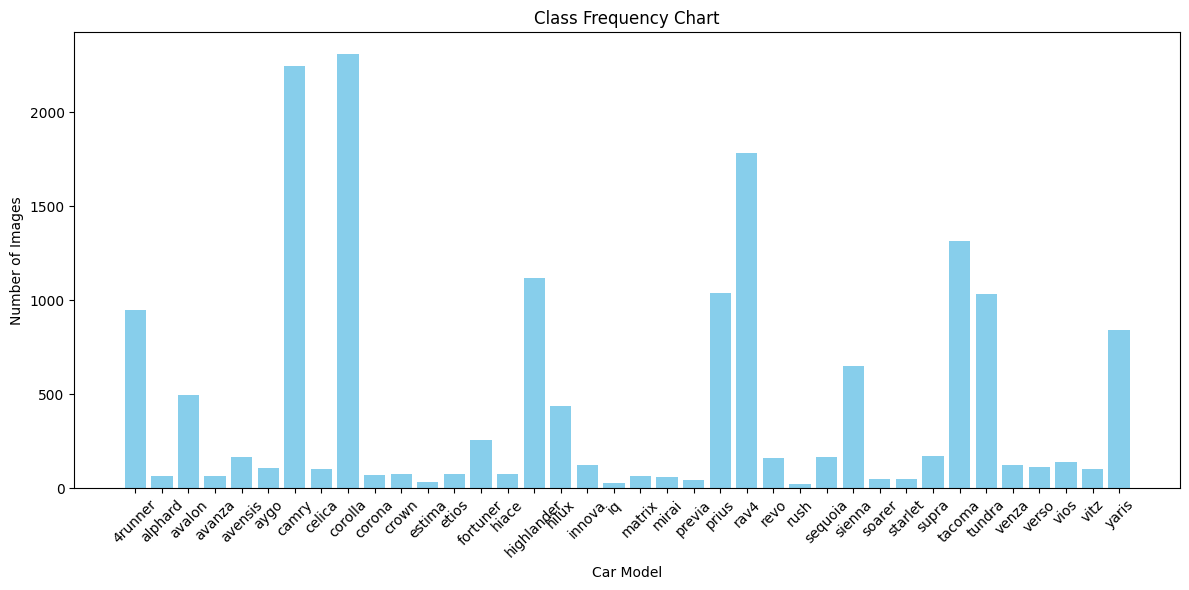

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title('Class Frequency Chart')
plt.xlabel('Car Model')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()



In [5]:
# تبدیل لیبل‌ها به اعداد
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)



In [13]:
len(numeric_labels)

16723

In [6]:
# شمارش تعداد هر لیبل عددی
numeric_label_counts = Counter(numeric_labels)


In [7]:
# انتخاب کلاس‌هایی که تعداد تصاویرشان بین 100 تا 200 است
classes_between_50_and_103 = [label for label, count in numeric_label_counts.items() if 50 <= count < 103]


In [8]:
# فیلتر کردن داده‌ها برای 10 کلاس عددی انتخاب‌شده
filtered_images = []
filtered_labels = []

for img_path, numeric_label in zip(image_paths, numeric_labels):
    if numeric_label in classes_between_50_and_103:
        filtered_images.append(img_path)
        filtered_labels.append(numeric_label)  # لیبل عددی رو ذخیره می‌کنیم


In [9]:
label_filtered = Counter(filtered_labels)
label_filtered

Counter({36: 102,
         7: 101,
         10: 77,
         14: 75,
         12: 74,
         9: 70,
         1: 64,
         3: 63,
         19: 63,
         20: 57})

In [10]:
min_count = min(label_filtered.values())
min_count

57

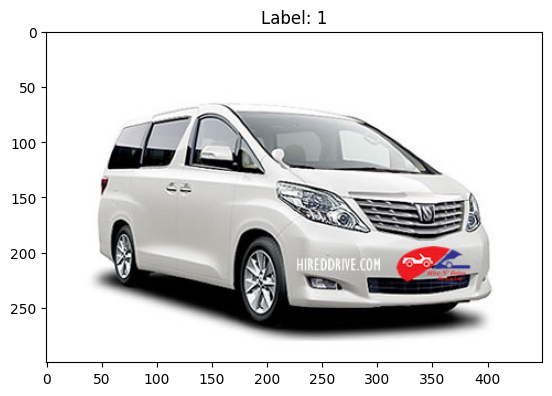

In [8]:

# انتخاب یک تصویر دلخواه از filtered_images (مثلاً اولین تصویر)
image_path = filtered_images[2]
label = filtered_labels[2]  # برچسب متناظر با تصویر

# بارگذاری تصویر
img = cv2.imread(image_path)

# تبدیل رنگ‌ها از BGR به RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# نمایش تصویر
plt.imshow(img_rgb)
plt.title(f"Label: {label}")  # نمایش برچسب در عنوان
plt.axis('on')  # برای عدم نمایش محورها
plt.show()


In [11]:
resized_images = []
for img_path in filtered_images:
    img = cv2.imread(img_path)
    if img is not None:
        img_resized = cv2.resize(img, (224, 224))
        resized_images.append(img_resized)


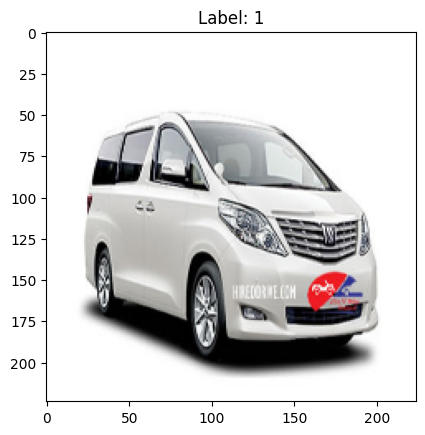

In [10]:
# انتخاب تصویر و برچسب
img1 = resized_images[2]  # استفاده از تصویر از لیست resized_images
label1 = filtered_labels[2]  # برچسب متناظر با تصویر

# تبدیل رنگ‌ها از BGR به RGB (در صورتی که تصویر در BGR باشد)
img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# نمایش تصویر
plt.imshow(img_rgb1)
plt.title(f"Label: {label1}")  # نمایش برچسب در عنوان
plt.axis('on')  # برای نمایش محورها
plt.show()


In [12]:
processed_images = []

# حلقه برای پردازش هر تصویر
for img in resized_images:
    # نرمال‌سازی مقادیر پیکسلی بین 0 و 1
    img_normalized = img / 255.0
    
    # اضافه کردن تصویر نرمال‌شده به لیست
    processed_images.append(img_normalized)


In [ ]:
# دسته‌بندی تصاویر بر اساس لیبل
class_to_images = defaultdict(list)
for img, label in zip(processed_images, filtered_labels):
    class_to_images[label].append(img)


In [ ]:

# شمارش تعداد نمونه‌های هر کلاس بعد از نرمال‌سازی
label_counts = Counter(filtered_labels)

# گرفتن لیبل‌ها و تعدادشون برای رسم
labels = list(label_counts.keys())
counts = list(label_counts.values())

# رسم نمودار
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='coral')
plt.xlabel('Car Model')
plt.ylabel('Number of Images')
plt.title('Class Frequency After Normalization')
plt.xticks(list(range(31)))
plt.tight_layout()
plt.show()


In [ ]:

# لیبل‌ها و تعدادشون
labels = list(label_counts.keys())
counts = list(label_counts.values())
total = sum(counts)
percentages = [count / total * 100 for count in counts]

# نمودار دایره‌ای
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=[f"{l} ({p:.1f}%)" for l, p in zip(labels, percentages)],
        autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution (%)')
plt.axis('equal')
plt.show()


In [13]:
# مرحله: متعادل‌سازی داده‌ها بر اساس min_count برای هر کلاس
balanced_images = []
balanced_labels = []

# ابتدا تصاویر و لیبل‌ها را به صورت دیکشنری بر اساس کلاس تقسیم می‌کنیم
class_to_images = {label: [] for label in classes_between_50_and_103}

for img, label in zip(processed_images, filtered_labels):
    class_to_images[label].append(img)

# حالا به اندازه min_count از هر کلاس انتخاب تصادفی می‌کنیم
for label in class_to_images:
    selected_imgs = random.choices(class_to_images[label], k=min_count)
    balanced_images.extend(selected_imgs)
    balanced_labels.extend([label] * min_count)

# تبدیل به آرایه numpy
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)


In [25]:
label_counts_balanced = Counter(balanced_labels)
label_counts_balanced

Counter({1: 57,
         3: 57,
         7: 57,
         9: 57,
         10: 57,
         12: 57,
         14: 57,
         19: 57,
         20: 57,
         36: 57})

In [13]:
len(balanced_images)

570

In [14]:
len(balanced_labels)

570

In [14]:
# تعریف روش‌های افزایش داده
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [15]:
# تعداد افزایشی که می‌خواهیم (مثلاً 5 برابر، چون داده اصلی هم داریم میشه 6 برابر)
augment_factor = 4

augmented_images = []
augmented_labels = []

for img, label in zip(balanced_images, balanced_labels):
    img = np.expand_dims(img, 0)  # تغییر شکل برای ورودی دیتاجن
    aug_iter = datagen.flow(img, batch_size=1)
    
    for _ in range(augment_factor):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_labels.append(label)

# اضافه کردن تصاویر اصلی هم به مجموعه نهایی
augmented_images.extend(balanced_images)
augmented_labels.extend(balanced_labels)


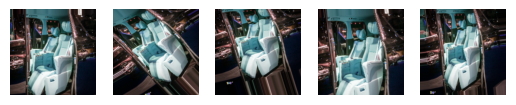

In [57]:
sample_image = balanced_images[0]  # به عنوان مثال، اولین تصویر
img_array2 = img_to_array(sample_image)
img_array2 = np.expand_dims(img_array2, axis=0)

# ایجاد یک generator برای تصاویر augmented
aug_iter2 = datagen.flow(img_array2, batch_size=1)

# نمایش تصاویر augmented برای تصویر نمونه
for i in range(5):  # مثلا ۵ تغییر مختلف از تصویر اصلی نمایش داده می‌شود
    aug_img2 = next(aug_iter2)[0]
    
    plt.subplot(1, 5, i+1)  # نمایش تصاویر در یک ردیف
    plt.imshow(aug_img2)
    plt.axis('off')  # مخفی کردن محورهای تصویر

plt.show()


In [16]:
# تبدیل به آرایه‌های NumPy
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


In [85]:
augmented_images.shape

(2280, 224, 224, 3)

In [86]:
augmented_labels.shape

(2280,)

In [17]:
# تقسیم به داده‌های آموزش و تست با نسبت ۸۰-۲۰
X_train, X_test, y_train, y_test = train_test_split(
    augmented_images, augmented_labels, test_size=0.2, random_state=42, stratify=augmented_labels
)


In [18]:


# گزارش ابعاد هر مجموعه
print(f"تعداد تصاویر آموزش: {X_train.shape[0]}")
print(f"تعداد تصاویر تست: {X_test.shape[0]}")
print(f"ابعاد تصاویر آموزش: {X_train.shape}")
print(f"ابعاد تصاویر تست: {X_test.shape}")


تعداد تصاویر آموزش: 2280
تعداد تصاویر تست: 570
ابعاد تصاویر آموزش: (2280, 224, 224, 3)
ابعاد تصاویر تست: (570, 224, 224, 3)


In [19]:
# بارگذاری مدل VGG16 بدون لایه Fully Connected
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg = Model(inputs=base_model_vgg.input, outputs=base_model_vgg.output)


In [19]:
# بارگذاری مدل VGG16 بدون لایه FC (fully connected)
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# خلاصه مدل
base_model_vgg.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# پیش‌پردازش تصاویر
X_train_pp = preprocess_input(X_train)
X_test_pp = preprocess_input(X_test)


In [20]:
# استخراج ویژگی‌ها
vgg_train_features = model_vgg.predict(X_train, batch_size=32)
vgg_test_features = model_vgg.predict(X_test , batch_size=32)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2779s 39s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step


In [21]:
# تبدیل به بردار یک‌بعدی
features_train_vgg_flat = vgg_train_features.reshape(vgg_train_features.shape[0], -1)
features_test_vgg_flat = vgg_test_features.reshape(vgg_test_features.shape[0], -1)


In [ ]:
# مدل SVM با کرنل خطی
svm_clf = SVC(kernel='linear')
svm_clf.fit(features_train_vgg_flat, y_train)


SVC(kernel='linear')

In [ ]:
# پیش‌بینی
y_pred_svm = svm_clf.predict(features_test_vgg_flat)


In [24]:
# محاسبه معیارها
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average='weighted')
rec_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')



In [25]:
print("📊 SVM روی ویژگی‌های VGG:")
print(f"Accuracy: {acc_svm*100:.2f}%")
print(f"Precision: {prec_svm*100:.2f}%")
print(f"Recall: {rec_svm*100:.2f}%")
print(f"F1 Score: {f1_svm*100:.2f}%")


📊 SVM روی ویژگی‌های VGG:
Accuracy: 96.49%
Precision: 96.68%
Recall: 96.49%
F1 Score: 96.47%


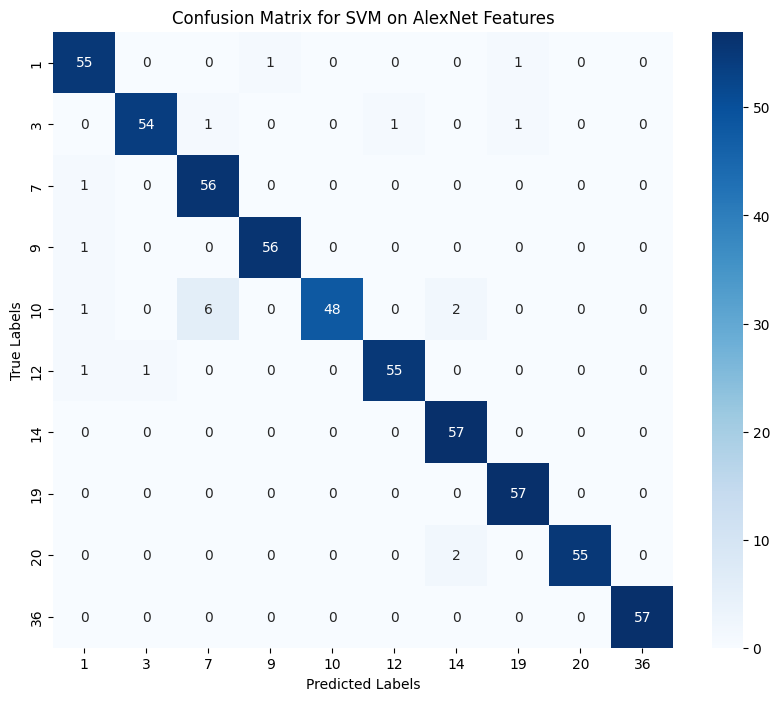

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
class_labels = sorted(np.unique(y_test))  # لیبل‌های عددی کلاس‌ها

# رسم بصری با seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM on AlexNet Features')
plt.show()


In [22]:
# مدل SVM با کرنل خطی
svm_clf_poly = SVC(kernel='poly')
svm_clf_poly.fit(features_train_vgg_flat, y_train)


SVC(kernel='poly')

In [23]:
# پیش‌بینی
y_pred_svm_poly = svm_clf_poly.predict(features_test_vgg_flat)
# محاسبه معیارها
acc_svm_poly = accuracy_score(y_test, y_pred_svm_poly)
prec_svm_poly = precision_score(y_test, y_pred_svm_poly, average='weighted')
rec_svm_poly = recall_score(y_test, y_pred_svm_poly, average='weighted')
f1_svm_poly = f1_score(y_test, y_pred_svm_poly, average='weighted')



In [24]:
print("📊 SVM روی ویژگی‌های VGG:")
print(f"Accuracy: {acc_svm_poly*100:.2f}%")
print(f"Precision: {prec_svm_poly*100:.2f}%")
print(f"Recall: {f1_svm_poly*100:.2f}%")
print(f"F1 Score: {f1_svm_poly*100:.2f}%")


📊 SVM روی ویژگی‌های VGG:
Accuracy: 93.33%
Precision: 93.59%
Recall: 93.30%
F1 Score: 93.30%
